In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz" -O training_images_full.npz
!wget "https://sussex.box.com/shared/static/axweldiirenlc4a6xn06l6heiuawodpa.npz" -O training_images_subset.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/2ss21w2g8nd8fshhtu9r2ww2mm04xh9f.npz" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/65pyy3pjnkl5yda7ra4rvhcd89l6i7fq.npzz" -O examples.npz

--2023-05-10 17:53:55--  https://sussex.box.com/shared/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from sussex.box.com attempted to set domain to box.net
Location: /public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz [following]
--2023-05-10 17:53:55--  https://sussex.box.com/public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from sussex.box.com attempted to set domain to box.net
Location: https://sussex.app.box.com/public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz [following]
--2023-05-10 17:53:55--  https://sussex.app.box.com/public/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Conn

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images_full.npz', '69927c788396d4b8c05d33d1650b2aa66076c0f0')
confirm_checksum('training_images_subset.npz', '5e2690718c7b1a0d14db54f844e6e22453f5eb71')
confirm_checksum('test_images.npz', 'aed32f84664e906624c8af13b5462cbded13d539')
confirm_checksum('examples.npz', '2ea08d7b6d76b56de97325fe51daad72afaa3d73')

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [ ]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
  plt.show()

# this funciton goes through height and width of all image data step by step
# starting from step_value until the step_value (to avoid corners which is bad for features)
# because trying to extract data from raw image data takes realy long which is
# a huge problem. finally adds all the locations to a list to be used to find 
# key points for sift to compute descriptors. the link below provides knowledge about how this function work
# https://pynative.com/python-range-function/#h-range-start-stop-step
def find_feature_loc(step_value, locations, img): 
  for y in range(step_value, img.shape[1], step_value):
    for x in range(step_value, img.shape[2], step_value):
      locations.append((y, x))

def extract_feature_desc(descriptor_list, img, step_value, locations):
  for i in range(img.shape[0]): # goes through all images
    gray_img = cv2.cvtColor(img[i], cv2.COLOR_BGR2GRAY) # turns them into gray images to make it easier for sift to work
    key_points = [cv2.KeyPoint(x, y, step_value) for x, y in locations]# cv2.KeyPoint stores a keypoint, i.e. a point feature 
    # found by one of many available keypoint detectors, cv::FAST, cv::StarDetector, cv::SURF etc. 
    # according to https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/class_cv_KeyPoint.html
    # also learned how to use sift and cv2 from https://docs.opencv.org/3.4/index.html
    descriptors = sift.compute(gray_img, key_points)[1]  
    descriptor_list.append(descriptors.flatten())


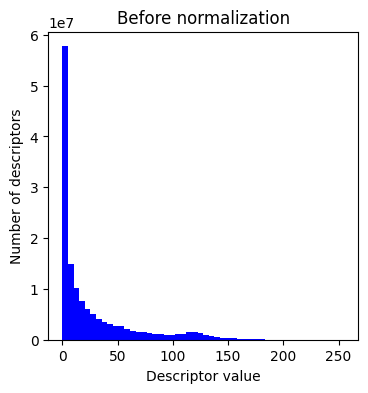

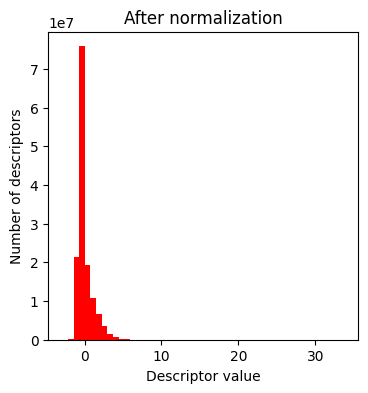

In [ ]:
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# this link was crucial for pre-processing phase https://scikit-learn.org/stable/modules/preprocessing.html
# load training file and split them into image and point data
train_data = np.load('training_images_full.npz', allow_pickle=True)
train_images = train_data['images']
train_pts = train_data['points']
train_pts = train_pts.reshape(train_pts.shape[0], -1) #turns the data into one dimensional array so that linear regrassion can use it

# split the training data into 80% / 20% ground truth for accuracy evaluation. but this reduces the accuracy because data is trained on less data
train_images, gt_images, train_pts, gt_pts = train_test_split(train_images, train_pts, test_size = 0.2)

# create swift
sift = cv2.SIFT_create()

# finds the feature locations in training images
step_value = 8 # increasing the step_value reduces both time and accuracy, decreasing does the reverse 
# according to my observations 7-8 are the best for both accuracy and time. but more than 8 decreases accuracy significantly
# NOTE: step_value = 7-8 aproximately takes 8 minutes to complete in colab
training_locations = []
find_feature_loc(step_value, training_locations, train_images)

# extracts the feature descriptors for the training images
train_descriptors = []
extract_feature_desc(train_descriptors, train_images, step_value, training_locations)
train_descriptors = np.array(train_descriptors)

# histogram of the descriptors before normalization
plt.figure(figsize=(4, 4))
plt.hist(train_descriptors.flatten(), bins=50, color='blue')
plt.title('Before normalization')
plt.xlabel('Descriptor value')
plt.ylabel('Number of descriptors')
plt.show()

# normalization for the training descriptors
scaler = StandardScaler()
train_descriptors = scaler.fit_transform(train_descriptors)

# histogram of the descriptors after normalization
plt.figure(figsize=(4, 4))
plt.hist(train_descriptors.flatten(), bins=50, color='red')
plt.title('After normalization')
plt.xlabel('Descriptor value')
plt.ylabel('Number of descriptors')
plt.show()

In [ ]:
# load subset training file and split them into image and point data
subset_data = np.load('training_images_subset.npz', allow_pickle=True)
subset_images = subset_data['images']
subset_pts = subset_data['points']
subset_pts = subset_pts.reshape(subset_pts.shape[0], -1) #turns the data into one dimensional array so that linear regrassion can use it

# finds the feature locations in subset images
subset_locations = []
find_feature_loc(step_value,subset_locations, subset_images)

# extracts the feature descriptors for the subset training images
subset_descriptors = []
extract_feature_desc(subset_descriptors, subset_images, step_value, subset_locations)
subset_descriptors = np.array(subset_descriptors)

# normalization for the subset descriptors
subset_descriptors = scaler.transform(subset_descriptors)

reg1 = LinearRegression().fit(train_descriptors, train_pts)
reg2 = LinearRegression().fit(subset_descriptors, subset_pts)

In [ ]:
# load testing file only as images because it has no landmark points
test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']

# finds the feature locations in testing images
test_locations = []
find_feature_loc(step_value, test_locations,test_images)

# extract the feature descriptors for the test images
test_descriptors = []
extract_feature_desc(test_descriptors, test_images, step_value, test_locations)
test_descriptors = np.array(test_descriptors)

# normalization for the testing descriptors
test_descriptors = scaler.transform(test_descriptors)

predicted_pts1 = reg1.predict(test_descriptors)
predicted_pts2 = reg2.predict(test_descriptors)

In [ ]:
# load example file only as images because it has no landmark points
example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']

# finds the feature locations in example images
example_locations = []
find_feature_loc(step_value, example_locations, example_images)

# extracts the feature descriptors for the example images
example_descriptors = []
extract_feature_desc(example_descriptors, example_images, step_value, example_locations)
example_descriptors = np.array(example_descriptors)

# normalization for the example image descriptors
example_descriptors = scaler.transform(example_descriptors)

example_predicted_pts1 = reg1.predict(example_descriptors)
example_predicted_pts2 = reg2.predict(example_descriptors)

In [ ]:
# finds the feature locations in ground truth images
gt_locations = []
find_feature_loc(step_value, gt_locations, gt_images)

# extracts the feature descriptors for the ground truth images
gt_descriptors = []
extract_feature_desc(gt_descriptors, gt_images, step_value, gt_locations)
gt_descriptors = np.array(gt_descriptors)

# normalization for the ground truth descriptors
gt_descriptors = scaler.transform(gt_descriptors)

gt_predicted_pts = reg1.predict(gt_descriptors)

In [ ]:
final_predicted_pts = np.concatenate((predicted_pts1, predicted_pts2), axis=1)
example_predicted_pts = np.concatenate((example_predicted_pts1, example_predicted_pts2), axis=1)

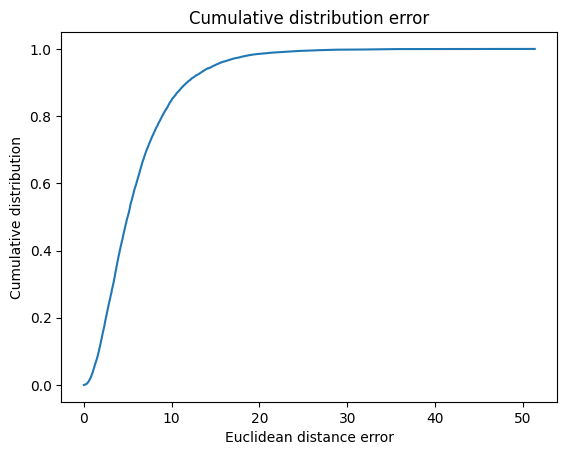

In [ ]:
# used this link to learn how to plot cumulative_distribution error
# https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
evaluation = euclid_dist(gt_predicted_pts, gt_pts)
sorted = np.sort(evaluation)
cumulative_distribution = np.arange(len(sorted)) / float(len(sorted))

plt.plot(sorted, cumulative_distribution)
plt.xlabel('Euclidean distance error')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative distribution error')
plt.show()

In [ ]:
save_as_csv(predicted_pts1)

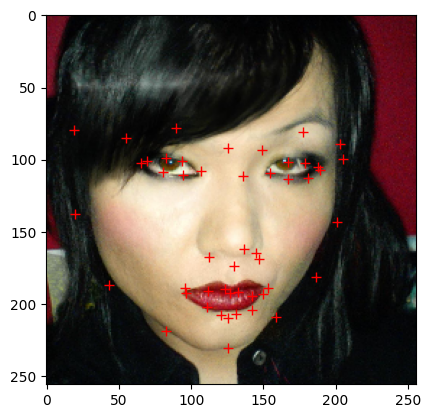

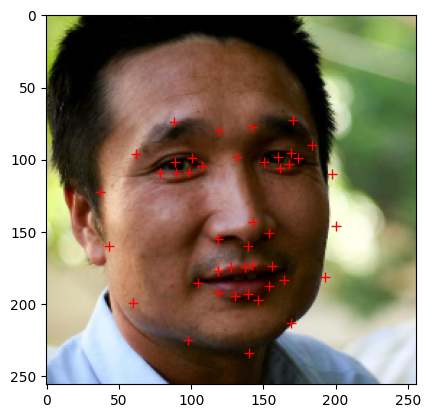

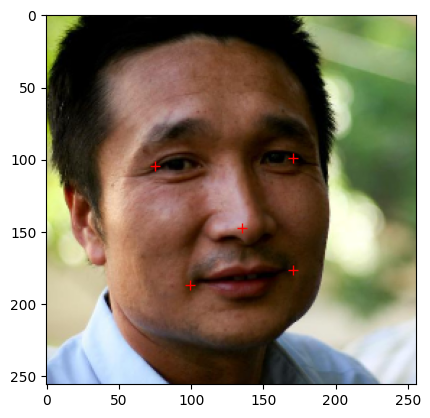

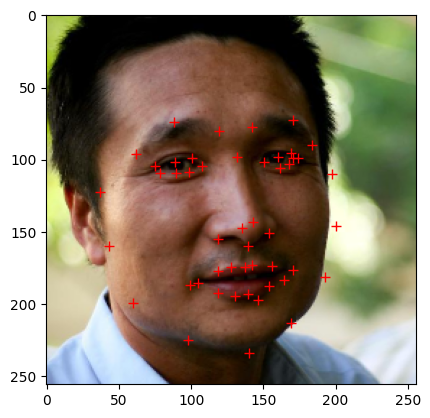

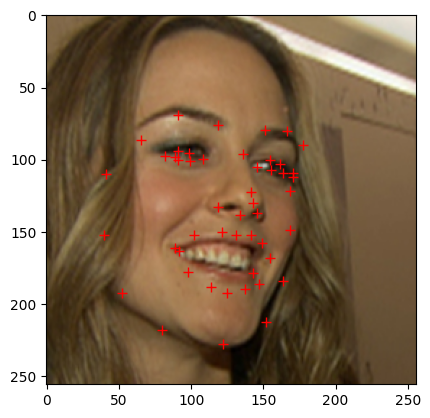

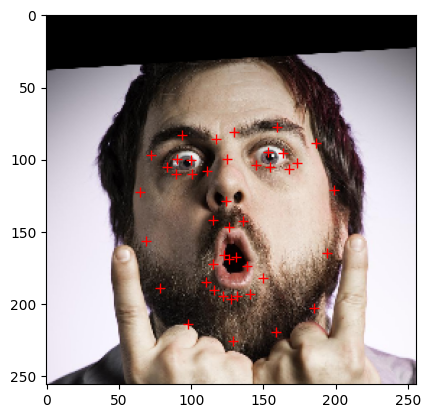

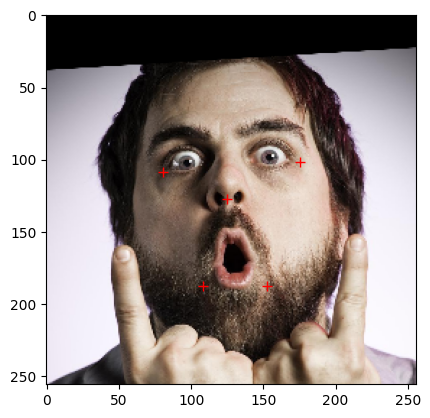

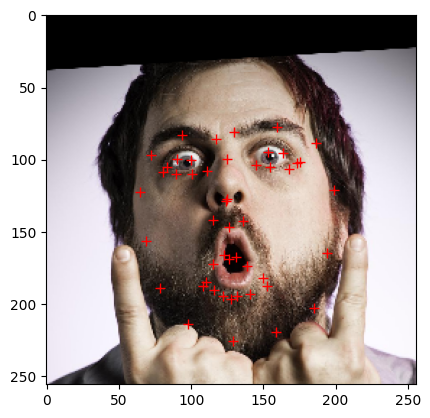

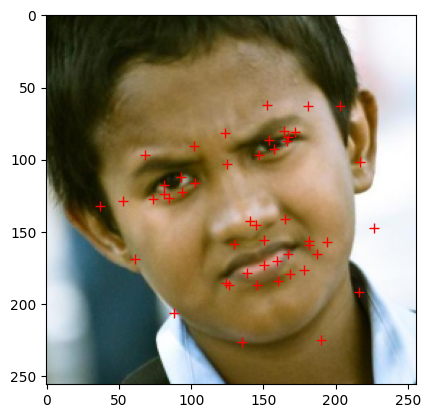

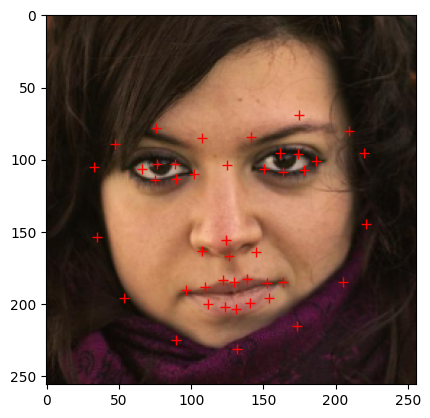

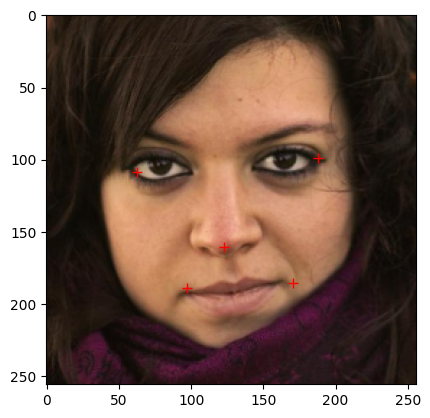

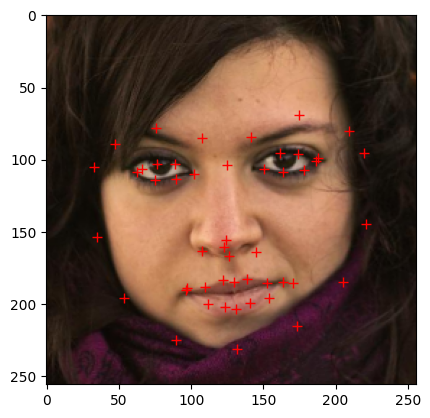

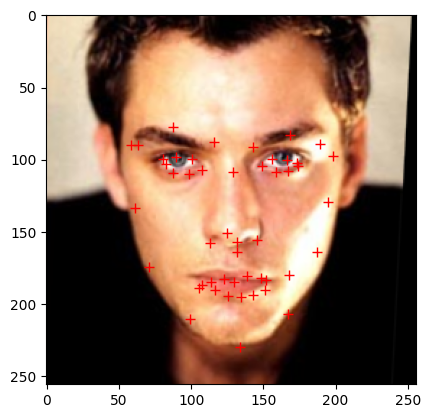

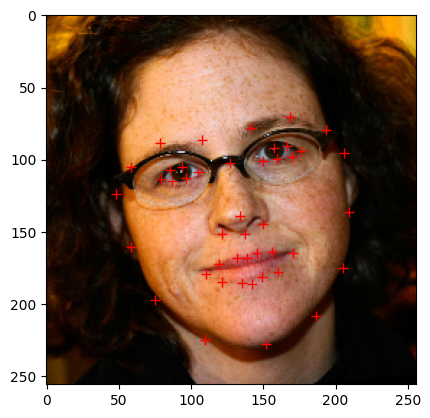

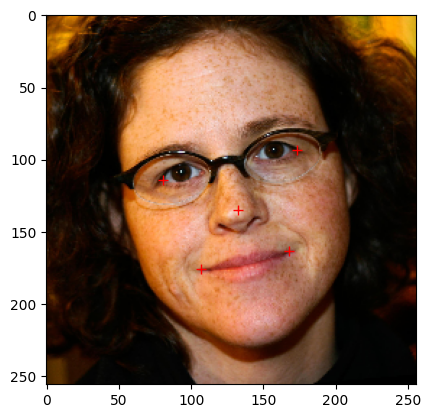

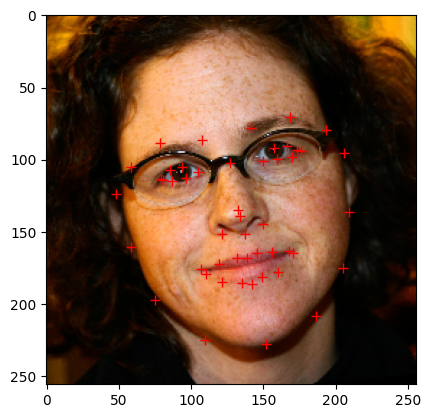

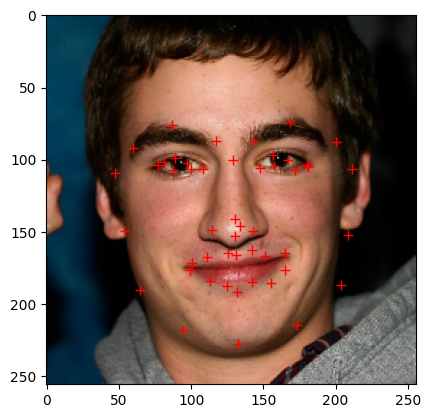

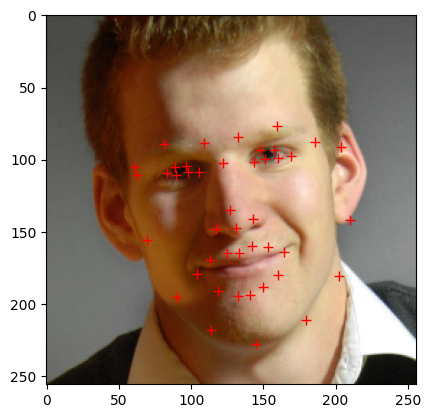

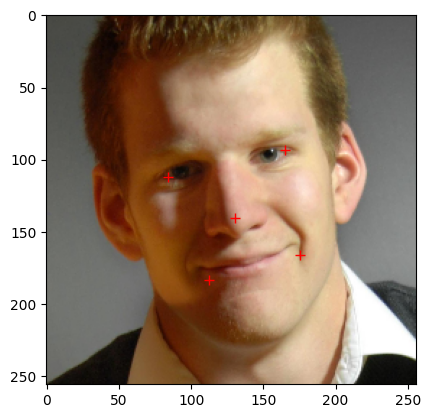

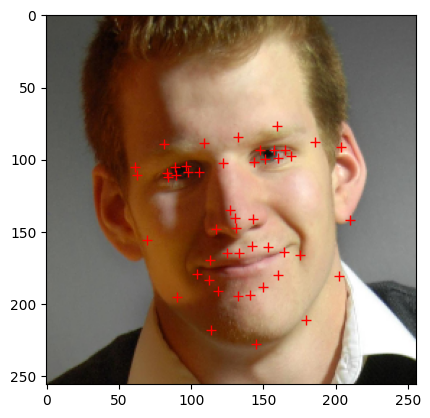

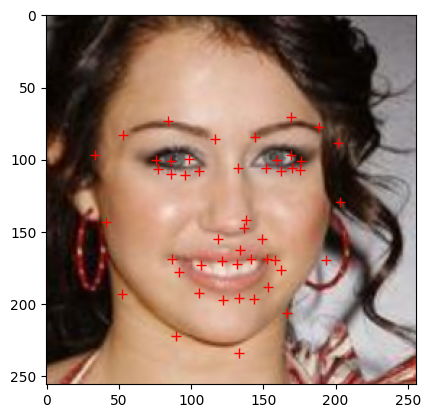

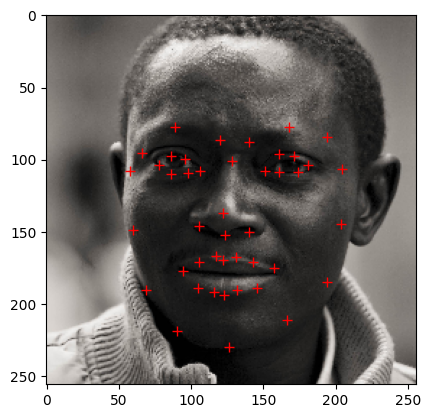

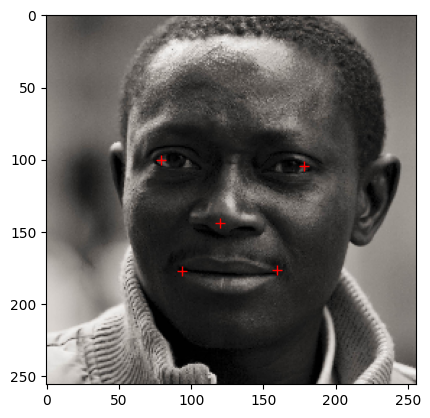

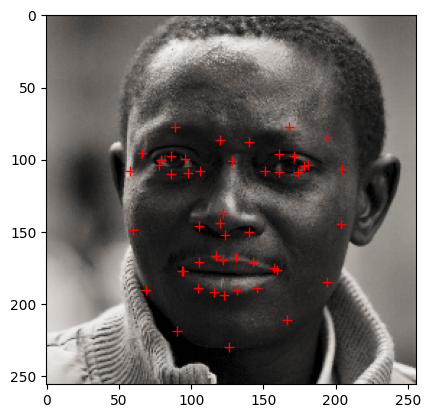

In [ ]:
for i in range(6):
  testing = test_images[i]
  example = example_images[i]
  testingpts = final_predicted_pts[i].reshape((-1, 2))
  examplepts1 = example_predicted_pts1[i].reshape((-1, 2))
  examplepts2 = example_predicted_pts2[i].reshape((-1, 2))
  examplepts = example_predicted_pts[i].reshape((-1, 2))
  visualise_pts(testing, testingpts)
  visualise_pts(example, examplepts1)
  visualise_pts(example, examplepts2)
  visualise_pts(example, examplepts)